## Load Data From .mat Files

In [1]:
import scipy.io as sio

In [2]:
filepath = '../mitGCM/data/'
kappa_OBS = sio.loadmat(filepath + 'kappa_OBS')['kappa']
mgrid = sio.loadmat(filepath + 'mgrid')['mgrid']
regional_logicals = sio.loadmat(filepath + 'regional_logicals')
reg_logic = {}
for key in ['ARC', 'CB', 'EB', 'NAt', 'reg', 'shelf', 'slope']:
    reg_logic[key] = regional_logicals['ii_' + key]
    
transect_start = sio.loadmat(filepath + 'CANBAR_transect')['coord1_ll'][0]
transect_end = sio.loadmat(filepath + 'CANBAR_transect')['coord2_ll'][0]

## Create Fields and Transects

In [3]:
from arctic_objects import *

In [4]:
Kappa_REG = KappaBG(r'CTL - $\kappa_{BG}$', mgrid, reg_logic, kappa_OBS, ver='REG')
canbarTransect = Transect(mgrid, transect_start, transect_end)

## Visualize Fields and Transects

In [5]:
import matplotlib.pyplot as plt

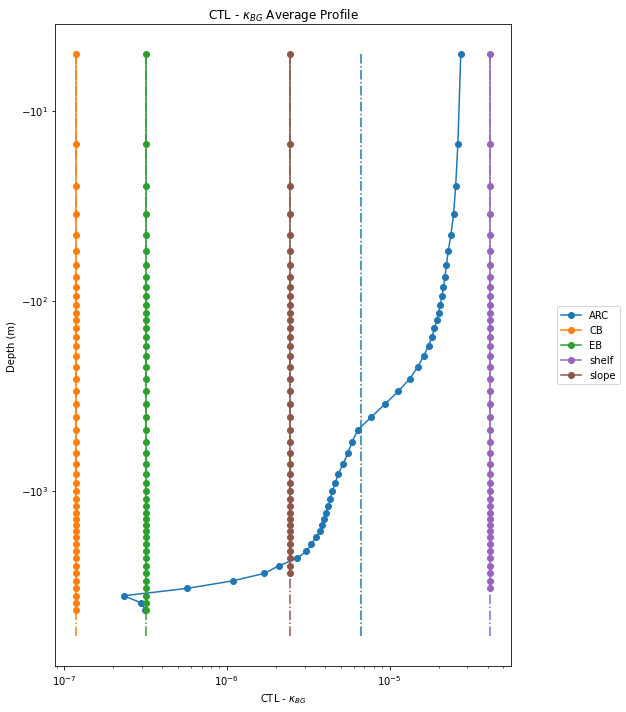

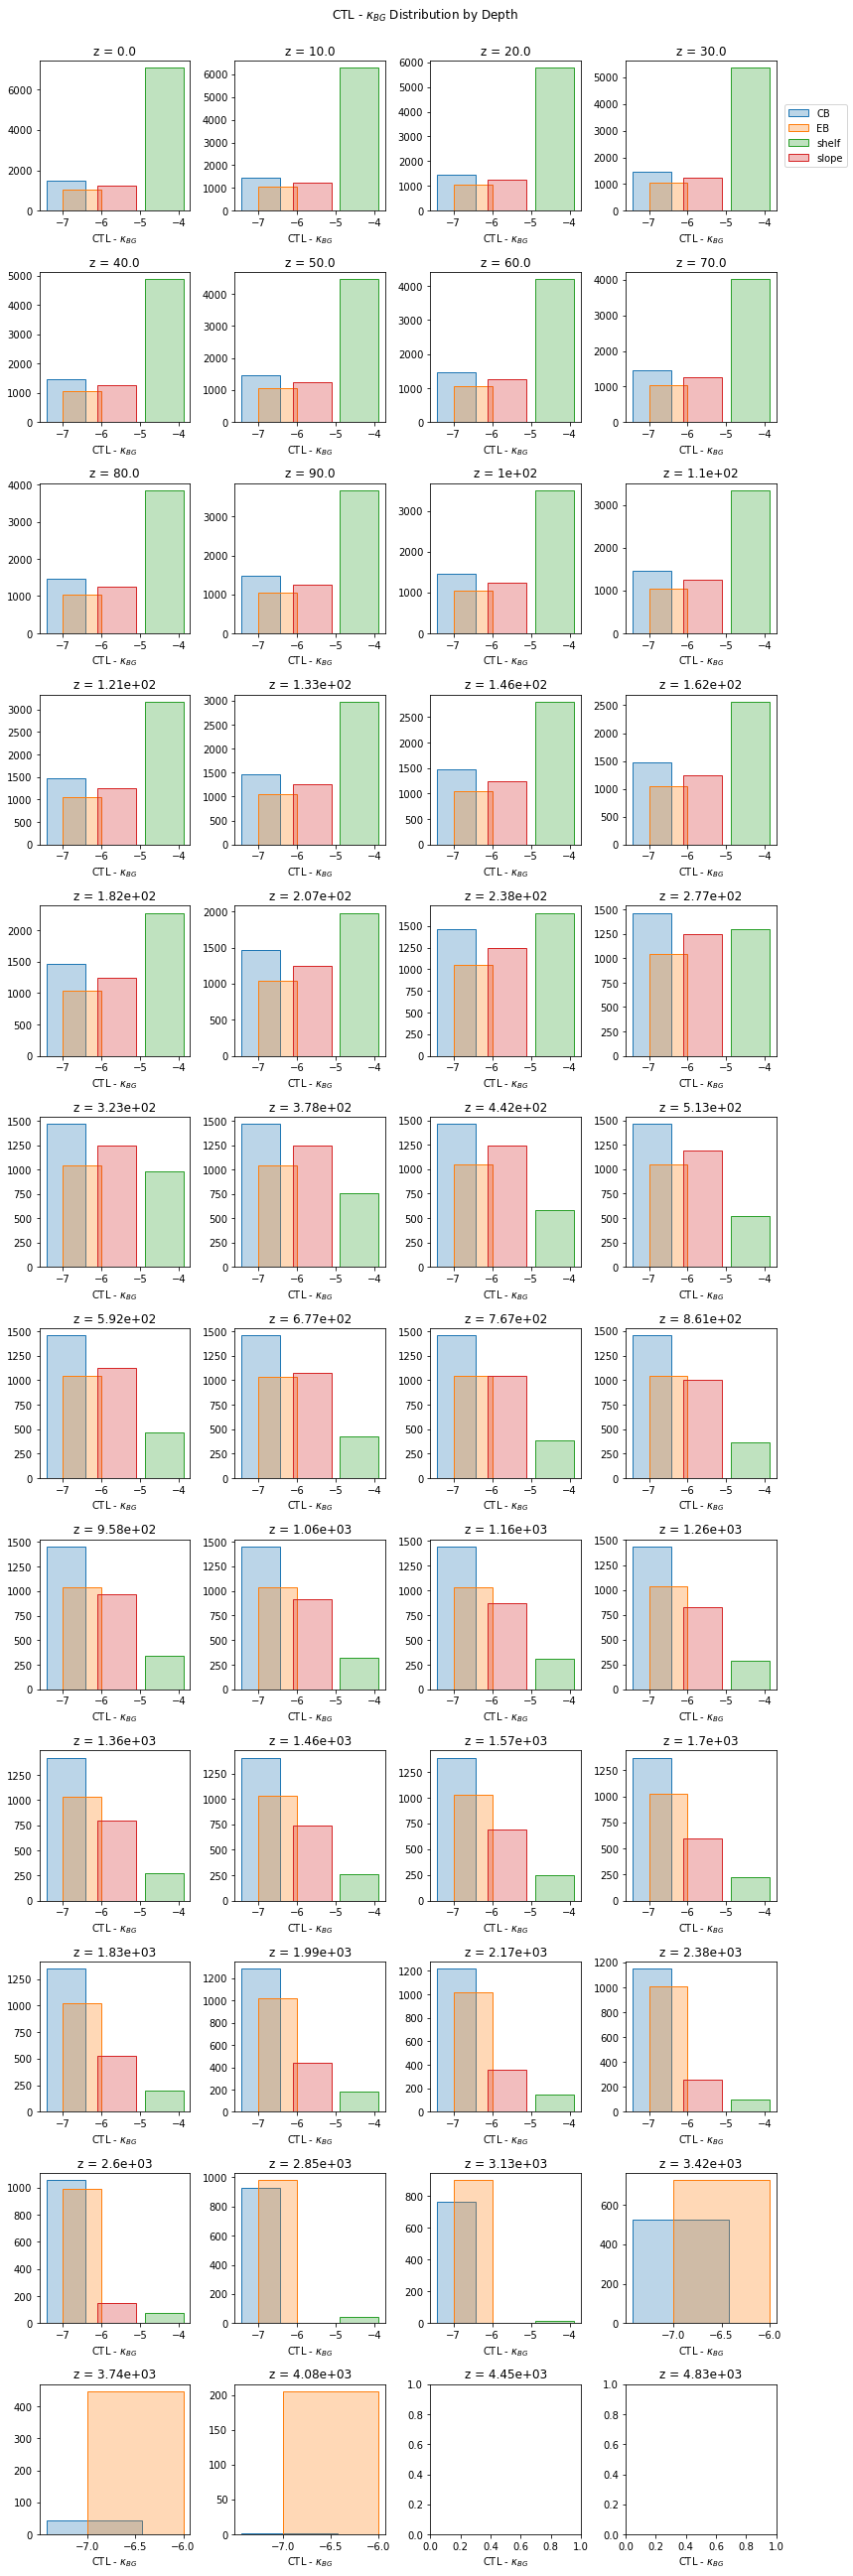

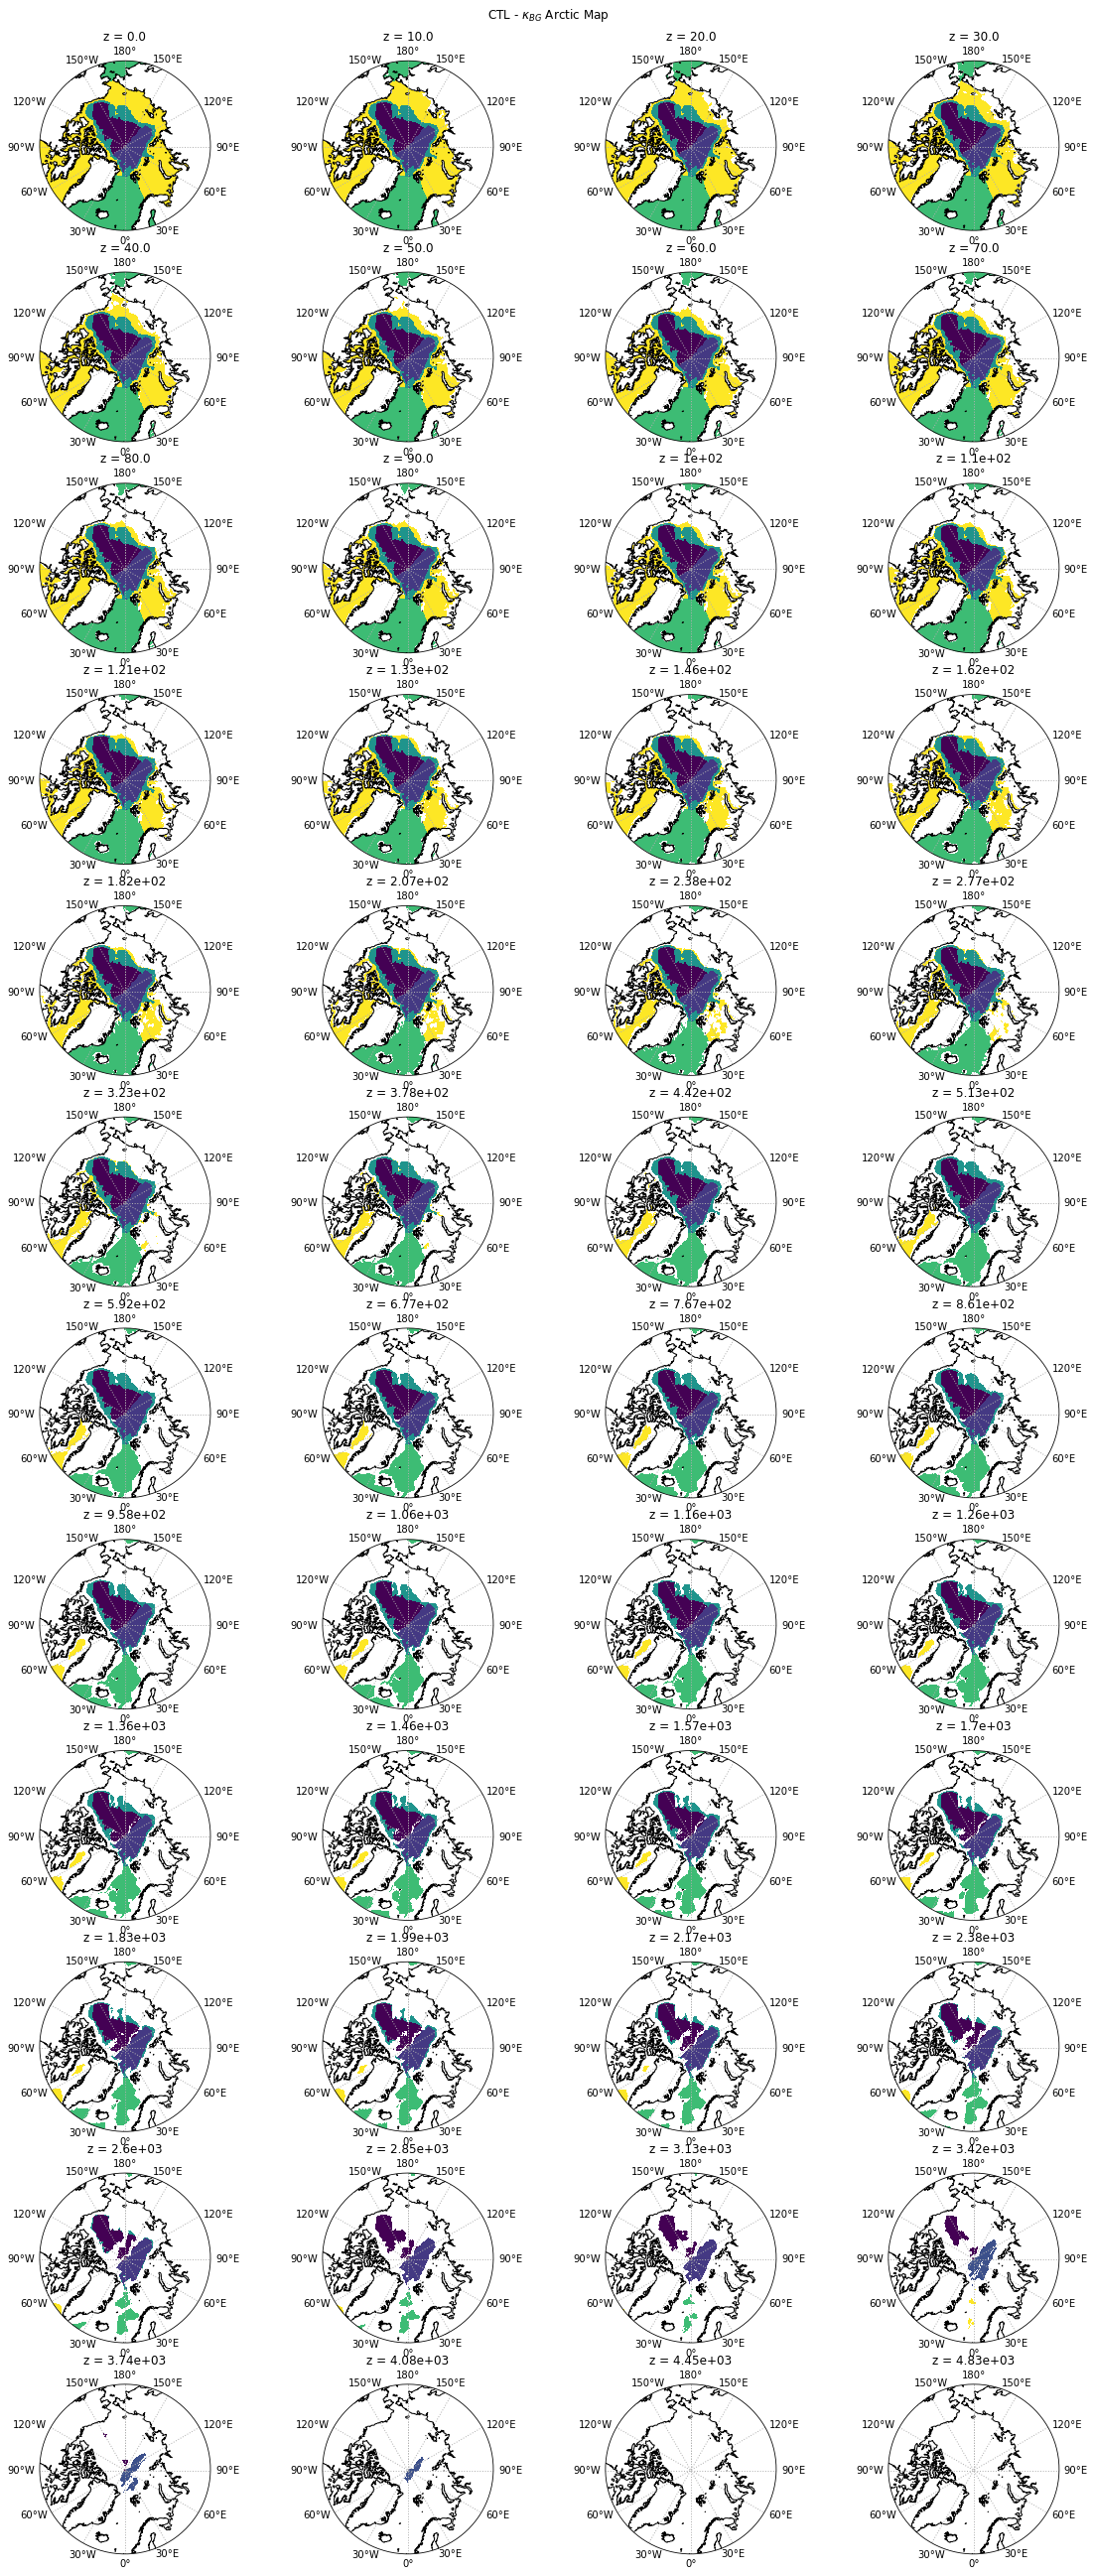

In [6]:
avg_prof = Kappa_REG.visualize_average_profiles(show=True)
dist = Kappa_REG.visualize_distributions(show=True)
maps = Kappa_REG.visualize_maps(show=True)

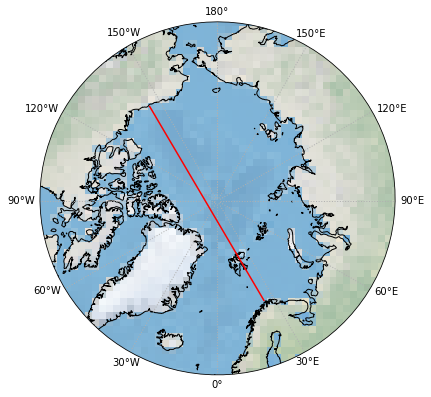

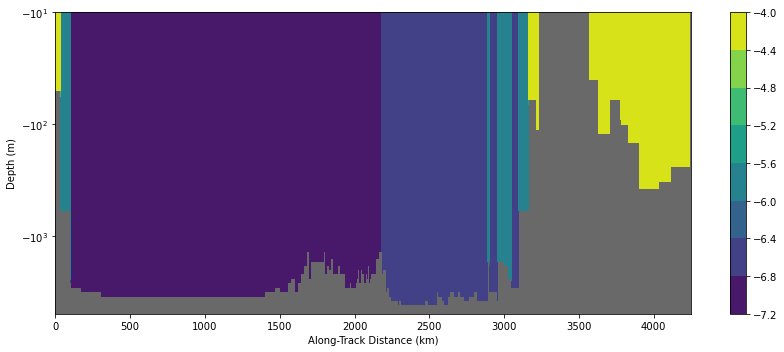

In [8]:
ctl = canbarTransect.visualize_line(show=True)
ct = canbarTransect.visualize_transect(Kappa_REG, show=True)